# Daily indices

https://azure.microsoft.com/en-us/products/azure-maps/?msockid=2e39c66c693c66a5151fd200687567d0

https://learn.microsoft.com/en-us/azure/azure-maps/

In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
import sys

from enum import Enum
from datetime import datetime, timedelta
from dotenv import load_dotenv
from typing import Dict, List, Optional, Tuple

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
load_dotenv("azure.env")

subscription_key = os.getenv('AZURE_MAPS_KEY')

## Helper

In [4]:
class IndexGroup(Enum):
    """Predefined index groups for Azure Maps Daily Indices."""
    OUTDOOR_RECREATION = 11
    HEALTH_FITNESS = 1
    HOME_GARDEN = 2
    TRAVEL = 3
    AGRICULTURE = 4


class ActivityIndex(Enum):
    """Specific activity indices with their IDs."""
    RUNNING = 1
    JOGGING = 2
    HIKING = 3
    BICYCLING = 4
    GOLF = 5
    TENNIS = 6
    SKATEBOARDING = 7
    OUTDOOR_CONCERT = 8
    KITE_FLYING = 9
    BEACH_POOL = 10
    SAILING = 11
    STARGAZING = 12
    FISHING = 13
    SKI_WEATHER = 15
    MOSQUITO_ACTIVITY = 17
    HUNTING = 20
    OUTDOOR_BARBECUE = 24
    LAWN_MOWING = 28
    OUTDOOR_ACTIVITY = 29


class AzureMapsDailyIndices:
    """
    A comprehensive class to interact with Azure Maps Daily Indices API.
    
    This API provides index values that help determine if weather conditions 
    are optimal for specific activities like outdoor sports, construction, or farming.
    """
    def __init__(self, subscription_key: str):
        """
        Initialize the Azure Maps Daily Indices client.
        
        Args:
            subscription_key (str): Azure Maps subscription key
        """
        self.subscription_key = subscription_key
        self.base_url = "https://atlas.microsoft.com/weather/indices/daily"
        self.api_version = "1.1"

    def _make_request(self, params: Dict) -> Optional[Dict]:
        """
        Make HTTP request to Azure Maps Daily Indices API.
        
        Args:
            params (Dict): Query parameters
            
        Returns:
            Optional[Dict]: JSON response or None if error
        """
        params['subscription-key'] = self.subscription_key
        params['api-version'] = self.api_version

        try:
            response = requests.get(f"{self.base_url}/json", params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error making request: {e}")
            if hasattr(e, 'response') and e.response:
                print(f"Response status: {e.response.status_code}")
                print(f"Response text: {e.response.text}")
            return None

    def get_all_indices(self,
                        lat: float,
                        lon: float,
                        duration: int = 1,
                        language: str = "en-US") -> Optional[Dict]:
        """
        Get all available daily indices for a location.
        
        Args:
            lat (float): Latitude
            lon (float): Longitude
            duration (int): Number of days (1, 5, 10, or 15, default: 1)
            language (str): Language for results (default: en-US)
            
        Returns:
            Optional[Dict]: All daily indices data
        """
        params = {
            'query': f"{lat},{lon}",
            'duration': duration,
            'language': language
        }

        return self._make_request(params)

    def get_specific_index(self,
                           lat: float,
                           lon: float,
                           activity: ActivityIndex,
                           duration: int = 1,
                           language: str = "en-US") -> Optional[Dict]:
        """
        Get daily indices for a specific activity.
        
        Args:
            lat (float): Latitude
            lon (float): Longitude
            activity (ActivityIndex): Specific activity index
            duration (int): Number of days (1, 5, 10, or 15, default: 1)
            language (str): Language for results (default: en-US)
            
        Returns:
            Optional[Dict]: Daily indices for the specific activity
        """
        params = {
            'query': f"{lat},{lon}",
            'indexId': activity.value,
            'duration': duration,
            'language': language
        }

        return self._make_request(params)

    def analyze_activity_forecast(self, data: Dict) -> Dict:
        """
        Analyze daily indices data and provide activity recommendations.
        
        Args:
            data (Dict): Daily indices response data
            
        Returns:
            Dict: Analysis results with recommendations
        """
        if not data or 'results' not in data:
            return {'error': 'Invalid data provided'}

        results = data['results']
        analysis = {
            'excellent_activities': [],
            'good_activities': [],
            'fair_activities': [],
            'poor_activities': [],
            'summary_stats': {},
            'recommendations': []
        }

        values = []
        categories_count = {
            'Excellent': 0,
            'Very Good': 0,
            'Good': 0,
            'Fair': 0,
            'Poor': 0
        }

        for result in results:
            activity_name = result.get('indexName', 'Unknown')
            category = result.get('category', 'Unknown')
            value = result.get('value', 0)
            description = result.get('description', '')

            values.append(value)

            # Categorize activities
            if category == 'Excellent':
                analysis['excellent_activities'].append({
                    'name':
                    activity_name,
                    'value':
                    value,
                    'description':
                    description
                })
                categories_count['Excellent'] += 1
            elif category in ['Very Good', 'Good']:
                analysis['good_activities'].append({
                    'name': activity_name,
                    'value': value,
                    'description': description
                })
                categories_count[category] += 1
            elif category == 'Fair':
                analysis['fair_activities'].append({
                    'name': activity_name,
                    'value': value,
                    'description': description
                })
                categories_count['Fair'] += 1
            elif category == 'Poor':
                analysis['poor_activities'].append({
                    'name': activity_name,
                    'value': value,
                    'description': description
                })
                categories_count['Poor'] += 1

        # Calculate summary statistics
        if values:
            analysis['summary_stats'] = {
                'average_index': sum(values) / len(values),
                'max_index': max(values),
                'min_index': min(values),
                'total_activities': len(values),
                'categories_distribution': categories_count
            }

        # Generate recommendations
        excellent_count = len(analysis['excellent_activities'])
        good_count = len(analysis['good_activities'])

        if excellent_count > 5:
            analysis['recommendations'].append(
                "🌟 Perfect weather for outdoor activities! Many excellent options available."
            )
        elif excellent_count + good_count > 10:
            analysis['recommendations'].append(
                "☀️ Great weather for most outdoor activities!")
        elif len(analysis['poor_activities']) > 10:
            analysis['recommendations'].append(
                "🏠 Consider indoor activities today - outdoor conditions are challenging."
            )
        else:
            analysis['recommendations'].append(
                "🌤️ Mixed conditions - choose activities based on individual forecasts."
            )

        return analysis

    def create_activity_dashboard(self,
                                  data: Dict,
                                  location_name: str = "Location") -> None:
        """
        Create a visual dashboard of daily indices.
        
        Args:
            data (Dict): Daily indices response data
            location_name (str): Name of the location for the title
        """
        if not data or 'results' not in data:
            print("No data available for visualization")
            return

        results = data['results']

        # Prepare data for visualization
        activities = [result.get('indexName', 'Unknown') for result in results]
        values = [result.get('value', 0) for result in results]
        categories = [result.get('category', 'Unknown') for result in results]

        # Create color mapping
        color_map = {
            'Excellent': '#28a745',
            'Very Good': '#17a2b8',
            'Good': '#ffc107',
            'Fair': '#fd7e14',
            'Poor': '#dc3545'
        }
        colors = [color_map.get(cat, '#6c757d') for cat in categories]

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Daily Activity Indices Dashboard - {location_name}',
                     fontsize=16,
                     fontweight='bold')

        # 1. Horizontal bar chart of all activities
        y_pos = range(len(activities))
        bars = ax1.barh(y_pos, values, color=colors, alpha=0.8)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(
            [name.replace(' Forecast', '') for name in activities], fontsize=8)
        ax1.set_xlabel('Index Value (0-10)')
        ax1.set_title('Activity Suitability Index')
        ax1.grid(axis='x', alpha=0.3)

        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, values)):
            ax1.text(value + 0.1,
                     bar.get_y() + bar.get_height() / 2,
                     f'{value:.1f}',
                     va='center',
                     fontsize=7)

        # 2. Category distribution pie chart
        category_counts = {}
        for cat in categories:
            category_counts[cat] = category_counts.get(cat, 0) + 1

        ax2.pie(category_counts.values(),
                labels=category_counts.keys(),
                colors=[
                    color_map.get(cat, '#6c757d')
                    for cat in category_counts.keys()
                ],
                autopct='%1.1f%%',
                startangle=90)
        ax2.set_title('Distribution by Category')

        # 3. Top 10 activities (highest index values)
        df = pd.DataFrame({
            'Activity': activities,
            'Value': values,
            'Category': categories
        })
        top_10 = df.nlargest(10, 'Value')

        bars3 = ax3.bar(range(len(top_10)),
                        top_10['Value'],
                        color=[
                            color_map.get(cat, '#6c757d')
                            for cat in top_10['Category']
                        ])
        ax3.set_xticks(range(len(top_10)))
        ax3.set_xticklabels(
            [name.replace(' Forecast', '') for name in top_10['Activity']],
            rotation=45,
            ha='right',
            fontsize=8)
        ax3.set_ylabel('Index Value')
        ax3.set_title('Top 10 Recommended Activities')
        ax3.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars3, top_10['Value']):
            ax3.text(bar.get_x() + bar.get_width() / 2,
                     bar.get_height() + 0.1,
                     f'{value:.1f}',
                     ha='center',
                     va='bottom',
                     fontsize=8)

        # 4. Index value distribution histogram
        ax4.hist(values,
                 bins=10,
                 color='skyblue',
                 alpha=0.7,
                 edgecolor='black')
        ax4.axvline(sum(values) / len(values),
                    color='red',
                    linestyle='--',
                    label=f'Average: {sum(values)/len(values):.1f}')
        ax4.set_xlabel('Index Value')
        ax4.set_ylabel('Number of Activities')
        ax4.set_title('Index Value Distribution')
        ax4.legend()
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

## Examples

In [5]:
client = AzureMapsDailyIndices(subscription_key)

### All indices

In [6]:
lat, lon = 47.6062, -122.3321

all_indices = client.get_all_indices(lat, lon)
all_indices

{'results': [{'indexName': 'Flight Delays',
   'indexId': -3,
   'dateTime': '2025-08-31T07:00:00-07:00',
   'value': 10.0,
   'category': 'Very Unlikely',
   'categoryValue': 5,
   'ascending': True,
   'description': 'Conditions are excellent for flying!'},
  {'indexName': 'Indoor Activity Forecast',
   'indexId': -2,
   'dateTime': '2025-08-31T07:00:00-07:00',
   'value': 4.1,
   'category': 'Fair',
   'categoryValue': 2,
   'ascending': True,
   'description': 'Expect only fair conditions for indoor activities.'},
  {'indexName': 'Running Forecast',
   'indexId': 1,
   'dateTime': '2025-08-31T07:00:00-07:00',
   'value': 6.0,
   'category': 'Good',
   'categoryValue': 3,
   'ascending': True,
   'description': 'Conditions are good for running outdoors.'},
  {'indexName': 'Jogging Forecast',
   'indexId': 2,
   'dateTime': '2025-08-31T07:00:00-07:00',
   'value': 6.0,
   'category': 'Good',
   'categoryValue': 3,
   'ascending': True,
   'description': 'Conditions are good for joggi

In [7]:
locations = {
    "San Diego, CA (Beach City)": (32.7157, -117.1611),
    "Denver, CO (Mountain City)": (39.7392, -104.9903),
    "Miami, FL (Tropical City)": (25.7617, -80.1918),
    "Seattle, WA (Rainy City)": (47.6062, -122.3321)
}

In [8]:
print("🌤️  Azure Maps Daily Indices API Demo\n")

for city, (lat, lon) in locations.items():
    print(f"\n📍 Activity Indices for {city}\n")

    # Get all indices for current day
    all_indices = client.get_all_indices(lat, lon)
    if all_indices:
        analysis = client.analyze_activity_forecast(all_indices)

        # Display excellent activities
        if analysis['excellent_activities']:
            print("🌟 EXCELLENT Activities Today:")
            for activity in analysis['excellent_activities'][:5]:  # Top 5
                print(f"  • {activity['name']}: {activity['value']:.1f}/10")
                print(f"    {activity['description'][:80]}...")

        # Display poor activities (things to avoid)
        if analysis['poor_activities']:
            print("\n🚫 Activities to Avoid Today:")
            for activity in analysis['poor_activities'][:3]:  # Top 3 to avoid
                print(f"  • {activity['name']}: {activity['value']:.1f}/10")
                print(f"    {activity['description'][:80]}...")

        # Summary statistics
        stats = analysis.get('summary_stats', {})
        if stats:
            print(f"\n📊 Summary:")
            print(f"  • Average Index: {stats.get('average_index', 0):.1f}/10")
            print(
                f"  • Best Activity Score: {stats.get('max_index', 0):.1f}/10")
            print(
                f"  • Total Activities Analyzed: {stats.get('total_activities', 0)}"
            )

            categories = stats.get('categories_distribution', {})
            print(
                f"  • Excellent Conditions: {categories.get('Excellent', 0)} activities"
            )
            print(
                f"  • Good+ Conditions: {categories.get('Very Good', 0) + categories.get('Good', 0)} activities"
            )

        # Recommendations
        if analysis['recommendations']:
            print(f"\n💡 Recommendation: {analysis['recommendations'][0]}")

    print("\n", "-" * 150)

🌤️  Azure Maps Daily Indices API Demo


📍 Activity Indices for San Diego, CA (Beach City)

🌟 EXCELLENT Activities Today:
  • Flying Travel Index: 0.0/10
    Conditions are excellent for flying!...
  • Fuel Economy Forecast: 9.4/10
    Weather conditions will be excellent for fuel economy....

🚫 Activities to Avoid Today:
  • Ski Weather Forecast: 0.0/10
    Expect poor conditions for skiing....
  • Home Energy Efficiency Forecast: 1.6/10
    Expect poor weather conditions for home energy efficiency....
  • Carwashing Forecast: 1.0/10
    Weather conditions are unfavorable for carwashing.  It is advisable to avoid car...

📊 Summary:
  • Average Index: 4.9/10
  • Best Activity Score: 10.0/10
  • Total Activities Analyzed: 49
  • Excellent Conditions: 2 activities
  • Good+ Conditions: 24 activities

💡 Recommendation: ☀️ Great weather for most outdoor activities!

 -----------------------------------------------------------------------------------------------------------------------------

## Reporting

In [9]:
# Get data for visualization
lat, lon = 34.0522, -118.2437  # Los Angeles

🎨 Creating activity dashboard visualization...


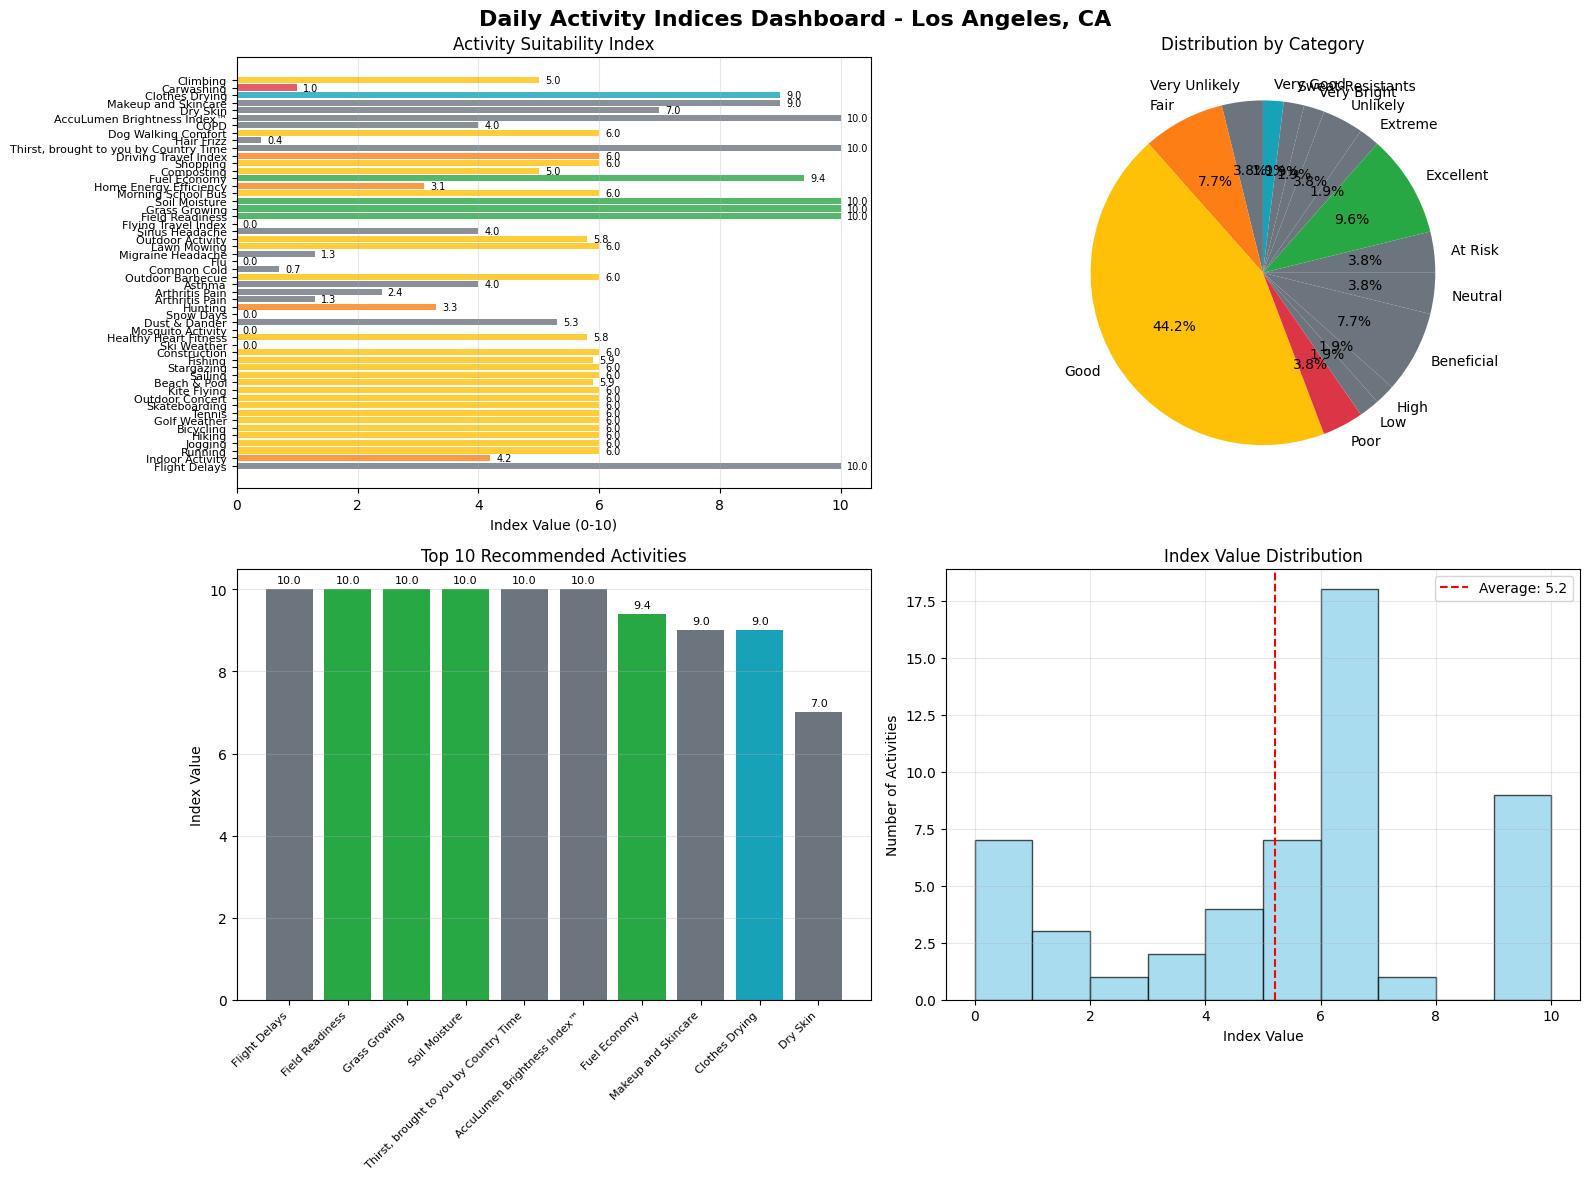

In [10]:
data = client.get_all_indices(lat, lon)
        
if data:
    print("🎨 Creating activity dashboard visualization...")
    df = client.create_activity_dashboard(data, "Los Angeles, CA")
else:
    print("No data available for visualization")

In [11]:
def load_azure_maps_data_to_dataframe(data):
    """
    Load Azure Maps daily indices data into a pandas DataFrame.
    
    Args:
        data (dict): Azure Maps API response containing 'results' key
        
    Returns:
        pd.DataFrame: Cleaned and processed DataFrame
    """

    # Extract the results list
    if 'results' in data:
        results = data['results']
    else:
        results = data

    # Create DataFrame from the results
    df = pd.DataFrame(results)

    # Convert datetime column to pandas datetime
    if 'dateTime' in df.columns:
        df['dateTime'] = pd.to_datetime(df['dateTime'])

        # Extract additional date/time components for analysis
        df['date'] = df['dateTime'].dt.date
        df['hour'] = df['dateTime'].dt.hour
        df['weekday'] = df['dateTime'].dt.day_name()

    # Clean up activity names (remove 'Forecast' suffix)
    if 'indexName' in df.columns:
        df['activity'] = df['indexName'].str.replace(
            ' Forecast', '').str.replace(' Index', '').str.strip()
        df['activity_clean'] = df['activity'].str.replace('™', '').str.replace(
            ', brought to you by Country Time', '')

    # Add activity categories for better analysis
    def categorize_activity(name):
        name_lower = name.lower()
        if any(word in name_lower for word in [
                'running', 'jogging', 'hiking', 'bicycling', 'tennis', 'golf',
                'skateboarding'
        ]):
            return 'Sports & Recreation'
        elif any(
                word in name_lower for word in
            ['beach', 'pool', 'sailing', 'fishing', 'kite', 'stargazing']):
            return 'Outdoor Leisure'
        elif any(
                word in name_lower for word in
            ['construction', 'lawn mowing', 'field', 'composting', 'soil']):
            return 'Work & Agriculture'
        elif any(word in name_lower for word in
                 ['arthritis', 'asthma', 'migraine', 'copd', 'flu', 'cold']):
            return 'Health & Medical'
        elif any(word in name_lower
                 for word in ['flying', 'flight', 'driving', 'travel']):
            return 'Transportation'
        elif any(word in name_lower
                 for word in ['shopping', 'indoor', 'barbecue', 'concert']):
            return 'Daily Life'
        elif any(word in name_lower
                 for word in ['skin', 'makeup', 'hair', 'thirst']):
            return 'Personal Care'
        else:
            return 'Other'

    if 'activity_clean' in df.columns:
        df['category'] = df['activity_clean'].apply(categorize_activity)

    # Add value interpretation
    def interpret_value(value):
        if value >= 8:
            return 'Excellent'
        elif value >= 6:
            return 'Good'
        elif value >= 4:
            return 'Fair'
        elif value >= 2:
            return 'Poor'
        else:
            return 'Very Poor'

    if 'value' in df.columns:
        df['value_interpretation'] = df['value'].apply(interpret_value)

    return df

In [12]:
df = load_azure_maps_data_to_dataframe(data)
df

,indexName,indexId,dateTime,value,category,categoryValue,ascending,description,date,hour,weekday,activity,activity_clean,value_interpretation
0,Flight Delays,-3,2025-08-31 07:00:00-07:00,10.0,Transportation,5,True,Conditions are excellent for flying!,2025-08-31,7,Sunday,Flight Delays,Flight Delays,Excellent
1,Indoor Activity Forecast,-2,2025-08-31 07:00:00-07:00,4.2,Daily Life,2,True,Expect only fair conditions for indoor activit...,2025-08-31,7,Sunday,Indoor Activity,Indoor Activity,Fair
2,Running Forecast,1,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions are good for running outdoors.,2025-08-31,7,Sunday,Running,Running,Good
3,Jogging Forecast,2,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions are good for jogging outdoors.,2025-08-31,7,Sunday,Jogging,Jogging,Good
4,Hiking Forecast,3,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions are good for hiking.,2025-08-31,7,Sunday,Hiking,Hiking,Good
5,Bicycling Forecast,4,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions are good for bicycling outdoors.,2025-08-31,7,Sunday,Bicycling,Bicycling,Good
6,Golf Weather Forecast,5,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions will be good for golf.,2025-08-31,7,Sunday,Golf Weather,Golf Weather,Good
7,Tennis Forecast,6,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions are good for playing tennis.,2025-08-31,7,Sunday,Tennis,Tennis,Good
8,Skateboarding Forecast,7,2025-08-31 07:00:00-07:00,6.0,Sports & Recreation,3,True,Conditions are good for skateboarding.,2025-08-31,7,Sunday,Skateboarding,Skateboarding,Good
9,Outdoor Concert Forecast,8,2025-08-31 07:00:00-07:00,6.0,Daily Life,3,True,Conditions are good for attending an outdoor c...,2025-08-31,7,Sunday,Outdoor Concert,Outdoor Concert,Good
